In [1]:
import os
import numpy as np

import parl
import gym
from parl import layers
from paddle import fluid
from parl.utils import logger,summary
from parl.utils import action_mapping # 将神经网络输出映射到对应的 实际动作取值范围 内
from parl.utils import ReplayMemory # 经验回放

D:\tool\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [17]:
from matplotlib import animation
import matplotlib.pyplot as plt
def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])        
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5)
    anim.save('./BipedalWalkerHardcore_result.gif', writer='imagemagick', fps=30)

In [3]:
#设置超参数
ACTION_REPEAT = 3
ACTION_NOISE = 0.3
ENV_SEED = 0 # ENV_SEED = 1
ACTOR_LR = 1e-4  # Actor网络更新的 learning rate
CRITIC_LR = 1e-4   # Critic网络更新的 learning rate
LOG_SIG_MIN = -20.0
LOG_SIG_MAX = 2.0
REWARD_SCALE = 5 #REWARD_SCALE = 1.5

GAMMA = 0.99        # reward 的衰减因子，一般取 0.9 到 0.999 不等
TAU = 0.005         # target_model 跟 model 同步参数 的 软更新参数
MEMORY_SIZE = 2e6   # replay memory的大小，越大越占用内存
MEMORY_WARMUP_SIZE = 1e4      # replay_memory 里需要预存一些经验数据，再从里面sample一个batch的经验让agent去learn

BATCH_SIZE = 256          # 每次给agent learn的数据数量，从replay memory随机里sample一批数据出来
TRAIN_TOTAL_STEPS = 1e6   # 总训练步数
TEST_EVERY_STEPS = 1e4    # 每个N步评估一下算法效果，episode求平均reward

In [4]:
#创建model
class ActorModel(parl.Model):
    def __init__(self, act_dim):
        hid1_size = 400
        hid2_size = 300
        self.fc1 = layers.fc(size=hid1_size, act='relu')
        self.fc2 = layers.fc(size=hid2_size, act='relu')
        self.mean_linear = layers.fc(size=act_dim)
        self.log_std_linear = layers.fc(size=act_dim)
    def policy(self, obs):
        hid1 = self.fc1(obs)
        hid2 = self.fc2(hid1)
        means = self.mean_linear(hid2)
        log_std = self.log_std_linear(hid2)
        log_std = layers.clip(log_std,min = LOG_SIG_MIN,max = LOG_SIG_MAX)
        return means, log_std
class CriticModel(parl.Model):
    def __init__(self):
        hid1_size = 400
        hid2_size = 300
        self.fc1 = layers.fc(size=hid1_size, act='relu')
        self.fc2 = layers.fc(size=hid2_size, act='relu')
        self.fc3 = layers.fc(size=1, act=None)

        self.fc4 = layers.fc(size=hid1_size, act='relu')
        self.fc5 = layers.fc(size=hid2_size, act='relu')
        self.fc6 = layers.fc(size=1, act=None)
    def value(self, obs, act):
        # 输入 state, action, 输出对应的Q(s,a)
        hid1 = self.fc1(obs)
        concat1 = layers.concat([hid1, act], axis=1)
        Q1 = self.fc2(concat1)
        Q1 = self.fc3(Q1)
        Q1 = layers.squeeze(Q1, axes=[1])

        hid2 = self.fc4(obs)
        concat2 = layers.concat([hid2, act], axis=1)
        Q2 = self.fc5(concat2)
        Q2 = self.fc6(Q2)
        Q2 = layers.squeeze(Q2, axes=[1])
        return Q1, Q2

In [5]:
from parl.algorithms import SAC

In [6]:
class BipedalWalkerAgent(parl.Agent):
    def __init__(self, algorithm, obs_dim, act_dim):
        assert isinstance(obs_dim, int)
        assert isinstance(act_dim, int)
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        super(BipedalWalkerAgent, self).__init__(algorithm)

        self.alg.sync_target(decay=0)

    def build_program(self):
        self.pred_program = fluid.Program()
        self.sample_program = fluid.Program()
        self.learn_program = fluid.Program()

        with fluid.program_guard(self.pred_program):
            obs = layers.data(
                name='obs', shape=[self.obs_dim], dtype='float32')
            self.pred_act = self.alg.predict(obs)
        with fluid.program_guard(self.sample_program):
            obs = layers.data(
                name='obs', shape=[self.obs_dim], dtype='float32')
            self.sample_act, _ = self.alg.sample(obs)

        with fluid.program_guard(self.learn_program):
            obs = layers.data(
                name='obs', shape=[self.obs_dim], dtype='float32')
            act = layers.data(
                name='act', shape=[self.act_dim], dtype='float32')
            reward = layers.data(name='reward', shape=[], dtype='float32')
            next_obs = layers.data(
                name='next_obs', shape=[self.obs_dim], dtype='float32')
            terminal = layers.data(name='terminal', shape=[], dtype='bool')
            self.critic_cost, self.actor_cost = self.alg.learn(
                obs, act, reward, next_obs, terminal)
    def predict(self, obs):
        obs = np.expand_dims(obs, axis=0)
        act = self.fluid_executor.run(
            self.pred_program, feed={'obs': obs},
            fetch_list=[self.pred_act])[0]
        return act
    
    def sample(self, obs):
        obs = np.expand_dims(obs, axis=0)
        act = self.fluid_executor.run(
            self.sample_program,
            feed={'obs': obs},
            fetch_list=[self.sample_act])[0]
        return act
    def learn(self, obs, act, reward, next_obs, terminal):
        feed = {
            'obs': obs,
            'act': act,
            'reward': reward,
            'next_obs': next_obs,
            'terminal': terminal
        }
        [critic_cost, actor_cost] = self.fluid_executor.run(
            self.learn_program,
            feed=feed,
            fetch_list=[self.critic_cost, self.actor_cost])
        self.alg.sync_target()
        return critic_cost[0], actor_cost[0]

In [11]:
# 评估 agent, 跑 1 个episode，返回总reward
def run_episode(env, agent, rpm):
    obs = env.reset()
    total_reward = 0
    steps = 0
    while True:
        action_fresh = False
        if steps % ACTION_REPEAT == 0:
            action_fresh = True
        steps += 1
        batch_obs = np.expand_dims(obs, axis=0)
        # 重复给出同一动作，隔一定步数探索一次
        if action_fresh:
            if rpm.size() < MEMORY_WARMUP_SIZE:
                action = env.action_space.sample()
                #action = agent.sample(batch_obs.astype('float32'))
                #action = np.squeeze(action)
                #action = action + 0.3*np.random.rand(len(action))
            else:
                action = agent.sample(batch_obs.astype('float32'))
                action = np.squeeze(action)
                #action = action + 0.3*np.random.rand(len(action))
        else:
            action = last_action
        next_obs, reward, done, info = env.step(action)
        if steps%2 == 0:
            env.render()
        #将掉落的reward修正为0进行训练 避免掉落对训练的影响过大
        if done == True and reward == -100:
            reward = -0.5
        rpm.append(obs, action, REWARD_SCALE * reward, next_obs, done)

        if rpm.size() > MEMORY_WARMUP_SIZE:
            batch_obs, batch_action, batch_reward, batch_next_obs, batch_terminal = rpm.sample_batch(
                BATCH_SIZE)
            agent.learn(batch_obs, batch_action, batch_reward, batch_next_obs,
                        batch_terminal)
        last_action = action
        obs = next_obs
        total_reward += reward
        if done:
            break
    return total_reward, steps
def evaluate(env, agent):
    obs = env.reset()
    total_reward = 0
    steps = 0
    while True:
        steps+=1
        batch_obs = np.expand_dims(obs, axis=0)
        action = agent.predict(batch_obs.astype('float32'))
        action = np.squeeze(action)
        next_obs, reward, done, info = env.step(action)
        #logger.info('reward each step:step {}, reward {}'.format(steps,reward))
        #env.render()
        if steps % 2 == 0:
            frames.append(env.render(mode = 'rgb_array'))
        obs = next_obs
        total_reward += reward
        if done:
            break
    return total_reward,steps

In [12]:
# 创建环境
env = gym.make('BipedalWalkerHardcore-v3')
env.seed(ENV_SEED)
env.reset()
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
print('act_dim:{},obs_dim:{}，max_action:{}'.format(act_dim,obs_dim,max_action))
actor = ActorModel(act_dim)
critic = CriticModel()
algorithm = SAC(
    actor,critic,max_action=max_action, gamma=GAMMA, tau=TAU, actor_lr=ACTOR_LR, critic_lr=CRITIC_LR)
ckpt = 'steps_1000025.ckpt'
agent = BipedalWalkerAgent(algorithm, obs_dim, act_dim)
agent.restore(ckpt)
rpm = ReplayMemory(int(MEMORY_SIZE), obs_dim, act_dim)

act_dim:4,obs_dim:24，max_action:1.0
[06-27 22:16:07 MainThread @machine_info.py:88] Cannot find available GPU devices, using CPU now.
[06-27 22:16:08 MainThread @machine_info.py:88] Cannot find available GPU devices, using CPU now.
[06-27 22:16:08 MainThread @machine_info.py:88] Cannot find available GPU devices, using CPU now.


In [ ]:
# 开始训练
while total_steps < TRAIN_TOTAL_STEPS:
    train_reward, steps = run_episode(env, agent, rpm)
    total_steps += steps
    logger.info('Steps: {} Reward: {}'.format(total_steps, train_reward))
    #ckpt = 'work/steps_{}.ckpt'.format(total_steps)
    #agent.save(ckpt)
    if total_steps // TEST_EVERY_STEPS >= test_flag:
        while total_steps // TEST_EVERY_STEPS >= test_flag:
            test_flag += 1
            evaluate_reward = evaluate(env, agent)
            logger.info('Steps {}, Evaluate reward: {}'.format(
                total_steps, evaluate_reward))

[06-27 22:23:15 MainThread @<ipython-input-20-be4d75dba7ea>:12] Steps 279, Evaluate reward: -40.47541878484048,test_flag :1
[06-27 22:23:22 MainThread @<ipython-input-20-be4d75dba7ea>:12] Steps 615, Evaluate reward: -21.326242097856564,test_flag :2
[06-27 22:23:47 MainThread @<ipython-input-20-be4d75dba7ea>:12] Steps 1732, Evaluate reward: 166.64123122412332,test_flag :3
[06-27 22:23:51 MainThread @<ipython-input-20-be4d75dba7ea>:12] Steps 1898, Evaluate reward: -73.60653233483403,test_flag :4
[06-27 22:24:17 MainThread @<ipython-input-20-be4d75dba7ea>:12] Steps 3091, Evaluate reward: 304.5454989482416,test_flag :5


2020-06-27 22:24:18,513-WARNING: MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
2020-06-27 22:24:18,515-INFO: Animation.save using <class 'matplotlib.animation.PillowWriter'>


KeyboardInterrupt: 

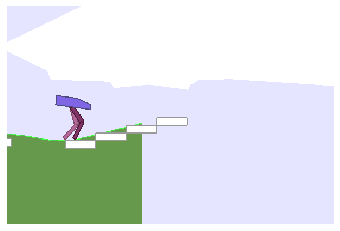

In [20]:
# 开始测试
test_flag = 0
total_steps = 0
add_reward = 0
frames = []
while total_steps < TRAIN_TOTAL_STEPS:
    test_flag+=1
    evaluate_reward,steps = evaluate(env, agent)
    total_steps+=steps
    if evaluate_reward > 0:
        add_reward += evaluate_reward
    logger.info('Steps {}, Evaluate reward: {},test_flag :{}'.format(total_steps, evaluate_reward,test_flag))
    if evaluate_reward > 300:
        display_frames_as_gif(frames)
    frames.clear()
    if test_flag % 100 == 0:
        logger.info('Steps {}, 100 means Evaluate reward: {}'.format(total_steps, add_reward/100))
        add_reward = 0

In [21]:
env.close()